In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir('../../notebook_format')
from formats import load_style
load_style()

In [2]:
os.chdir(path)
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 8, 6 # change default figure size

# 1. magic to print version
# 2. magic so that the notebook will reload external python modules
%load_ext watermark
%load_ext autoreload 
%autoreload 2

from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,keras

Using TensorFlow backend.


Ethen 2016-08-13 12:58:43 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.1
keras 1.0.6


## Problem Description

The problem we are going to look at in this example is the international airline passengers prediction problem (a time series problem). This is a problem where we're given a year and a month, the task is to predict the number of international airline passengers in units of 1,000. The data ranges from January 1949 to December 1960 or 12 years, with 144 observations.

The dataset is available for free from the [DataMarket webpage](https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line) as a .csv download with the filename "international-airline-passengers.csv".

In [3]:
# the last three rows are empty
filename = 'international-airline-passengers.csv'
data = pd.read_csv( filename, skip_footer = 3 )
data.columns = [ 'time', 'value' ]
data.head()

,time,value
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


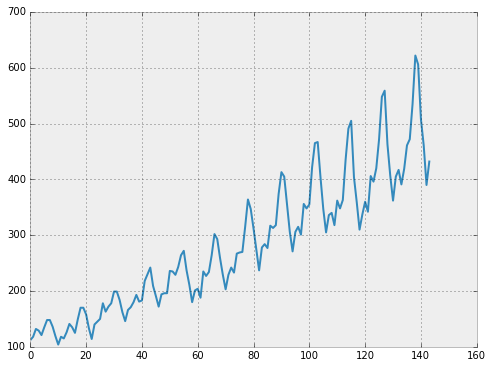

In [4]:
plt.plot(data['value'])
plt.show()

The time series prediction problem is basically a regression problem. That is, given the number of passengers (in units of thousands) this month, what will be the number of passengers next month. We can write a simple function to convert our single column of data into a two-column dataset. The first column containing this month’s (t) passenger count and the second column containing next month’s (t+1) passenger count, to be predicted.

In [5]:
# split into train and test sets, note that for
# time series data, the sequence of the value is important,
# hence we'll split the data using index ordering
n_data = data.shape[0]
n_train = int( n_data * 0.67 )
train, test = data[:n_train], data[n_train:n_data]
print( train.shape[0], test.shape[0] )

96 48


In [6]:
# shift the value
def create_data( value, shift ):
    X = value.iloc[:-shift].values
    y = value.shift(-shift).iloc[:-shift].values
    return X, y

shift = 1
X_train, y_train = create_data( train['value'], shift )
X_test, y_test = create_data( test['value'], shift )

# e.g. we're using the first value 112 to predict the
# next value 118; 118 to predict 132 and so on
print(X_train[:4])
print(y_train[:4])

[112 118 132 129]
[ 118.  132.  129.  121.]


We'll start by using a simple network with 1 input feature, 1 hidden layer with 8 neurons and an output layer. The model is trained using mean squared error loss. After training we will evaluate its performances using both numbers and visualization.

In [7]:
# create and fit a multi-layer perceptron (neural network) model
model = Sequential()
model.add(Dense( 20, input_dim = shift, activation = 'relu' ))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [8]:
# set it to a high number of epoch and use early stopping;
# here if validation loss does not increase for 2 epochs, stop the training,
# note that it's a bad idea to using the same set of data for validation
# and testing
callback = EarlyStopping( monitor = 'val_loss', patience = 2, verbose = 0 )
model.fit( X_train, y_train, nb_epoch = 500, 
           batch_size = 2, verbose = 0, callbacks = [callback],
           validation_data = ( X_test, y_test ) )

In [9]:
# generate predictions for training and testing
train_pred = model.predict(X_train)
test_pred  = model.predict(X_test)

# initialize an nan array with the same size
# as the original data, and fill in the index value,
# note that we're shifting the predictions so that 
# their x-axis are alined with the original dataset
data_train_pred = np.full( ( n_data, 1 ), np.nan )
train_shift_end = train_pred.shape[0] + shift
data_train_pred[shift:train_shift_end] = train_pred

data_test_pred = np.full( ( n_data, 1 ), np.nan )
test_shift_start = train_shift_end + shift
test_shift_end = test_shift_start + test_pred.shape[0]
data_test_pred[test_shift_start:test_shift_end] = test_pred

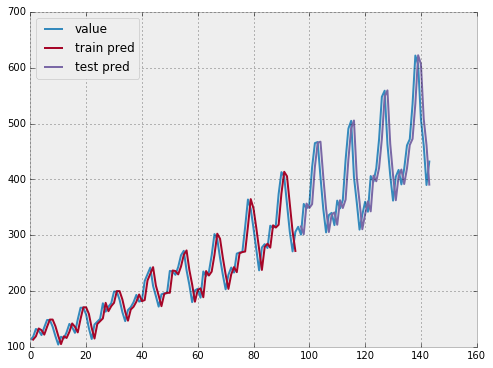

In [10]:
# plot baseline and predictions
plt.plot(data['value'])
plt.plot(data_train_pred, label = 'train pred')
plt.plot(data_test_pred, label = 'test pred')
plt.legend(loc = 'upper left')
plt.show()

In [11]:
# estimate model performance
train_score = model.evaluate( X_train, y_train, verbose = 0 )
test_score  = model.evaluate( X_test, y_test, verbose = 0 )

# we take the square root of mean squared error loss,
# to transform the error into the same unit as the input
print('Train Score: ', np.sqrt(train_score) )
print('Test Score: ', np.sqrt(test_score) )

Train Score:  23.2710974281
Test Score:  48.4868375401


Taking the square root of the performance estimates, we can see that the model has an average error of 23 passengers (in thousands) on the training dataset and 48 passengers (in thousands) on the test dataset.


### Window Method

We can also phrase the problem so that multiple recent time steps can be used to make the prediction for the next time step. This is called the window method, and the size of the window is a parameter that can be tuned for each problem.

For example, given the current time (t) we want to predict the value at the next time in the sequence (t + 1), we can use the current time (t) as well as the two prior times (t-1 and t-2). Hence the input variables are values at time $t-2$, $t-1$, $t$ and the output variable is the value at $t+1$.

In [12]:
# shift the value
def create_data( value, shift ):
    """
    given a pandas Series, generate shift
    number of new data 
    """
    y = value.shift(-shift).iloc[:-shift].values    
    X = np.zeros( ( len(value) - shift, shift ) )   
    for s in range(shift):        
        X[:, s] = value.shift(-s).iloc[:-shift].values
    
    return X, y

In [13]:
shift = 3
X_train, y_train = create_data( train['value'], shift )
X_test, y_test = create_data( test['value'], shift )

# print example, here we're setting the 
# window size (shift) to 3, hence we're using
# the first three value 112, 118, 132
# to predict the fourth value 129 and so on
print('Original Data:\n', train['value'].values[:4])
print('\nInput Data:\n', X_train[:4])
print('\nOutput Data:\n', y_train[:4])

Original Data:
 [112 118 132 129]

Input Data:
 [[ 112.  118.  132.]
 [ 118.  132.  129.]
 [ 132.  129.  121.]
 [ 129.  121.  135.]]

Output Data:
 [ 129.  121.  135.  148.]


We'll then copy and paste the training and evaluation code to see how whether this method leads to better performances. Both the window size and the network architecture were not tuned, this is just a demonstration of how to frame a prediction problem. 

In [21]:
model = Sequential()
model.add(Dense( 20, init = 'he_normal', input_dim = shift, activation = 'relu' ))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'rmsprop')

In [22]:
callback = EarlyStopping( monitor = 'val_loss', patience = 2, verbose = 0 )
history = model.fit( X_train, y_train, nb_epoch = 500, 
                     batch_size = 2, verbose = 0, callbacks = [callback],
                     validation_data = ( X_test, y_test ) )

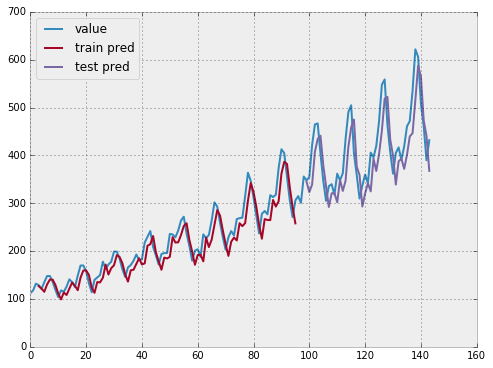

Train Score:  25.4066458968
Test Score:  51.8938652736


In [23]:
# generate predictions for training and testing
train_pred = model.predict(X_train)
test_pred  = model.predict(X_test)

# initialize an nan array with the same size
# as the original data, and fill in the index value,
# note that we're shifting the predictions so that 
# their x-axis are alined with the original dataset
data_train_pred = np.full( ( n_data, 1 ), np.nan )
train_shift_end = train_pred.shape[0] + shift
data_train_pred[shift:train_shift_end] = train_pred

data_test_pred = np.full( ( n_data, 1 ), np.nan )
test_shift_start = train_shift_end + shift
test_shift_end = test_shift_start + test_pred.shape[0]
data_test_pred[test_shift_start:test_shift_end] = test_pred

# plot baseline and predictions
plt.plot(data['value'])
plt.plot(data_train_pred, label = 'train pred')
plt.plot(data_test_pred, label = 'test pred')
plt.legend(loc = 'upper left')
plt.show()

# estimate model performance
train_score = model.evaluate( X_train, y_train, verbose = 0 )
test_score  = model.evaluate( X_test, y_test, verbose = 0 )

# we take the square root of mean squared error loss,
# to transform the error into the same unit as the input
print('Train Score: ', np.sqrt(train_score) )
print('Test Score: ', np.sqrt(test_score) )

Taking the square root of the performance scores we can see the average error on the training dataset was 21 passengers (in thousands per month) and the average error on the unseen test set was 44 passengers (in thousands per month).

There is another type of neural network that is dominating difficult machine learning problems that involve sequences of inputs called **recurrent neural networks (rnn)**. **Recurrent neural networks** have connections that have loops, adding feedback and memory to the networks over time. This memory allows this type of network to learn and generalize across sequences of inputs rather than individual patterns.

A powerful type of rnn called the **Long Short-Term Memory** has been shown to be particularly effective when stacked into a deep configuration, achieving state-of-the-art results on a diverse array of problems from language translation to automatic captioning of images and videos.

- [Blog: Time Series Prediction With Deep Learning in Keras](http://machinelearningmastery.com/time-series-prediction-with-deep-learning-in-python-with-keras/)
- http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/